In [1]:
import pandas as pd
import numpy as np
import pydeck as pdk

import wetterdienst
import matplotlib.pyplot as plt
import pathlib
import joblib
import geopandas as gpd
import contextily as ctx

In [2]:
data = pathlib.Path("data")
df = joblib.load(data/"cleaned_dataset.joblib")

In [3]:
sub =df[df.longitude == df.longitude.max()]
sub=df.sample(10000)

## Das Polygon für das Wetterdaten benötigt werden:

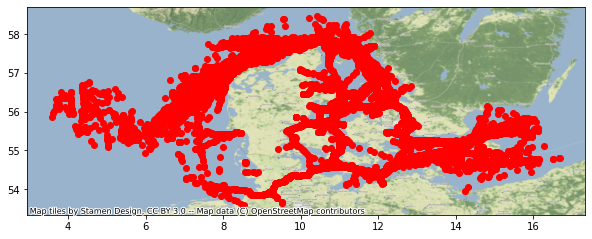

In [4]:
plt = gpd.GeoDataFrame(sub, geometry = gpd.points_from_xy(sub.longitude,sub.latitude),crs="EPSG:4326").plot(color="red", figsize=(10, 10))
ctx.add_basemap(plt, crs=4326)

In [5]:
df.latitude.mean(),df.longitude.mean()

(55.963095843572695, 11.299872706801684)

### Datenquellen

Interessante Wetterdaten sind: Wind-,Strömungs- Geschwindigkeit und Richtung, Salinity, Wellen- Höhe und Richtung, Temperatur, Druck

Diese können teilweise beim DWD abgefragt werden, aber vorallem bei Copernicus

In [6]:
from wetterdienst.dwd.observations import DwdObservationRequest, DwdObservationParameterSet, DwdObservationPeriod, DwdObservationResolution
from wetterdienst import Wetterdienst
from datetime import datetime

stations = DwdObservationRequest(
     parameter=[DwdObservationParameterSet.TEMPERATURE_AIR, DwdObservationParameterSet.WIND, DwdObservationParameterSet.VISIBILITY],
     resolution=DwdObservationResolution.HOURLY,
     period=DwdObservationPeriod.RECENT,
     start_date=datetime(2021, 1, 1),
     end_date=datetime(2021, 1, 2),
    tidy_data=True,
    humanize_parameters=True,
 ).nearby_radius(
        latitude=54,
        longitude=11.3,
        max_distance_in_km=20
   ).values.all().df.dropna()
stations

start_date and end_date filtering limited to defined periods [<Period.RECENT: 'recent'>]
100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


DATE STATION_ID    PARAMETER_SET  \
0   2021-01-01 00:00:00+00:00      00596  TEMPERATURE_AIR   
1   2021-01-01 01:00:00+00:00      00596  TEMPERATURE_AIR   
25  2021-01-01 00:00:00+00:00      00596  TEMPERATURE_AIR   
26  2021-01-01 01:00:00+00:00      00596  TEMPERATURE_AIR   
50  2021-01-01 00:00:00+00:00      00596             WIND   
..                        ...        ...              ...   
170 2021-01-01 20:00:00+00:00      02578  TEMPERATURE_AIR   
171 2021-01-01 21:00:00+00:00      02578  TEMPERATURE_AIR   
172 2021-01-01 22:00:00+00:00      02578  TEMPERATURE_AIR   
173 2021-01-01 23:00:00+00:00      02578  TEMPERATURE_AIR   
174 2021-01-02 00:00:00+00:00      02578  TEMPERATURE_AIR   

               PARAMETER  VALUE QUALITY  
0    TEMPERATURE_AIR_200    2.1       1  
1    TEMPERATURE_AIR_200    1.7       1  
25              HUMIDITY   87.0       1  
26              HUMIDITY   88.0       1  
50            WIND_SPEED    3.4       1  
..                   ...    ...     ...  
170             HUMIDITY   96.0       1  
171             HUMIDITY   97.0       1  
172             HUMIDITY   97.0       1  
173             HUMIDITY   97.0       1  
174             HUMIDITY   97.0       1  

[62 rows x 6 columns]

#### Copernicus Download über Subsetter Dienst

In [7]:
Polygon = []

### MIt dem motuclient können Daten heruntergeladen werden:

In [32]:
OUTPUT_DIRECTORY = str(data)
USERNAME = "hdreesmann"
PASSWORD = "Trw5UE2LuKYb_nT"
CURRENT_OUTPUT_FILENAME = "current_20210101_20210201.nc"
WIND_OUTPUT_FILENAME = "wind_20210101_20210201.nc"
WAVE_OUTPUT_FILENAME = "wave_20210101_20210201.nc"


In [117]:
current_data = f"""python -m motuclient --motu http://nrt.cmems-du.eu/motu-web/Motu \
    --service-id GLOBAL_ANALYSIS_FORECAST_PHY_001_024-TDS \
    --product-id global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh \
    --longitude-min 3 --longitude-max 17 --latitude-min 53 --latitude-max 59 \
    --date-min "2020-12-31 23:30:00" --date-max "2021-02-01 00:30:00" \
    --depth-min 0.493 --depth-max 0.4942 \
    --variable thetao --variable uo --variable vo --variable zos \
    --out-dir "{OUTPUT_DIRECTORY}" --out-name "{CURRENT_OUTPUT_FILENAME}" --user "{USERNAME}" --pwd "{PASSWORD}"
"""

wind_data = f"""python -m motuclient --motu http://nrt.cmems-du.eu/motu-web/Motu \
    --service-id WIND_GLO_WIND_L4_NRT_OBSERVATIONS_012_004-TDS \
    --product-id CERSAT-GLO-BLENDED_WIND_L4-V6-OBS_FULL_TIME_SERIE \
    --longitude-min 3 --longitude-max 17 --latitude-min 53 --latitude-max 59 \
    --date-min "2021-01-01 00:00:00" --date-max "2021-02-01 00:00:00" \
    --variable eastward_wind --variable eastward_wind_rms --variable height --variable northward_wind --variable northward_wind_rms --variable sampling_length \
    --variable surface_downward_eastward_stress --variable surface_downward_northward_stress --variable surface_type --variable wind_speed --variable wind_speed_rms \
    --variable wind_stress --variable wind_stress_curl --variable wind_stress_divergence \
    --variable wind_vector_curl --variable wind_vector_divergence \
    --out-dir {OUTPUT_DIRECTORY} --out-name {WIND_OUTPUT_FILENAME} --user {USERNAME} --pwd {PASSWORD}"""

wave_data = f"""python -m motuclient --motu http://nrt.cmems-du.eu/motu-web/Motu \
    --service-id GLOBAL_ANALYSIS_FORECAST_WAV_001_027-TDS \
    --product-id global-analysis-forecast-wav-001-027 \
    --longitude-min 3 --longitude-max 17 --latitude-min 53 --latitude-max 60 \
    --date-min "2021-01-01 00:00:00" --date-max "2021-02-01 00:00:00" \
    --variable VHM0 --variable VHM0_SW1 --variable VHM0_SW2 --variable VHM0_WW --variable VMDR --variable VMDR_SW1 --variable VMDR_SW2 --variable VMDR_WW --variable VPED --variable VSDX \
    --variable VSDY --variable VTM01_SW1 --variable VTM01_SW2 --variable VTM01_WW --variable VTM02 --variable VTM10 --variable VTPK \
    --out-dir {OUTPUT_DIRECTORY} --out-name {WAVE_OUTPUT_FILENAME} --user {USERNAME} --pwd {PASSWORD}"""

In [118]:
current_data

'python -m motuclient --motu http://nrt.cmems-du.eu/motu-web/Motu     --service-id GLOBAL_ANALYSIS_FORECAST_PHY_001_024-TDS     --product-id global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh     --longitude-min 3 --longitude-max 17 --latitude-min 53 --latitude-max 59     --date-min "2020-12-31 23:30:00" --date-max "2021-03-01 00:30:00"     --depth-min 0.493 --depth-max 0.4942     --variable thetao --variable uo --variable vo --variable zos     --out-dir "data" --out-name "current_20210101_20210301.nc" --user "hdreesmann" --pwd "Trw5UE2LuKYb_nT"\n'

In [17]:
import subprocess

In [119]:
subprocess.run(current_data, shell=True, check=True)

CompletedProcess(args='python -m motuclient --motu http://nrt.cmems-du.eu/motu-web/Motu     --service-id GLOBAL_ANALYSIS_FORECAST_PHY_001_024-TDS     --product-id global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh     --longitude-min 3 --longitude-max 17 --latitude-min 53 --latitude-max 59     --date-min "2020-12-31 23:30:00" --date-max "2021-03-01 00:30:00"     --depth-min 0.493 --depth-max 0.4942     --variable thetao --variable uo --variable vo --variable zos     --out-dir "data" --out-name "current_20210101_20210301.nc" --user "hdreesmann" --pwd "Trw5UE2LuKYb_nT"\n', returncode=0)

In [43]:
import asyncio

async def run(command):
    proc = await asyncio.create_subprocess_shell(
        command, 
        stderr=asyncio.subprocess.PIPE)
    _, stderr = await proc.communicate()
    print(f'[exited with {proc.returncode}]')
    if proc.returncode != 0 and stderr:
        print(f'[stderr]\n{stderr.decode()}')

async def download_all():
    await asyncio.gather(
    run(current_data),
    run(wave_data),
    run(wind_data)
)
        
        
def download_weather():
    asyncio.get_event_loop().run_until_complete(download_all())

In [120]:
import xarray as xr
current = xr.load_dataset(data / "current_20210101_20210301.nc")
wave = xr.load_dataset(data / "wave_20210101_20210301.nc")
wind = xr.load_dataset(data / "wind_20210101_20210301.nc")

In [121]:
current

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 73, longitude: 169, time: 1418)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 53.0 53.08 53.17 53.25 ... 58.83 58.92 59.0
  * time       (time) datetime64[ns] 2020-12-31T23:30:00 ... 2021-03-01T00:30:00
  * longitude  (longitude) float32 3.0 3.083 3.167 3.25 ... 16.83 16.92 17.0
Data variables:
    vo         (time, depth, latitude, longitude) float32 -0.02075 ... nan
    thetao     (time, depth, latitude, longitude) float32 10.04 10.0 ... nan nan
    uo         (time, depth, latitude, longitude) float32 0.03418 ... nan
    zos        (time, depth, latitude, longitude) float32 -0.3284 ... nan
Attributes: (12/25)
    title:                              hourly mean fields from Global Ocean ...
    easting:                            longitude
    northing:                           latitude
    history:                            2021/03/12 00:08:16 MERCATOR OCEAN Ne...
    source:                             MERCATOR PSY4QV3R1
    institution:                        MERCATOR OCEAN
    ...                                 ...
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              0.494025
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

In [46]:
wind

<xarray.Dataset>
Dimensions:                            (lat: 25, lon: 57, time: 236)
Coordinates:
  * lon                                (lon) float32 3.0 3.25 3.5 ... 16.75 17.0
  * time                               (time) datetime64[ns] 2021-01-01 ... 2...
  * lat                                (lat) float32 53.0 53.25 ... 58.75 59.0
Data variables: (12/15)
    surface_downward_eastward_stress   (time, lat, lon) float64 0.0416 ... 0....
    wind_stress_divergence             (time, lat, lon) float64 5.96e-08 ... nan
    northward_wind                     (time, lat, lon) float64 -4.48 ... 0.0...
    sampling_length                    (time, lat, lon) float32 5.0 5.0 ... 1.0
    wind_speed_rms                     (time, lat, lon) float64 0.7969 ... 0....
    northward_wind_rms                 (time, lat, lon) float64 1.203 ... 1.0
    ...                                 ...
    wind_stress                        (time, lat, lon) float64 0.0603 ... 0....
    wind_vector_divergence             (time, lat, lon) float64 3.6e-05 ... nan
    wind_stress_curl                   (time, lat, lon) float64 -5.029e-08 .....
    eastward_wind_rms                  (time, lat, lon) float64 1.297 ... 1.102
    surface_type                       (time, lat, lon) float32 0.0 0.0 ... 1.0
    surface_downward_northward_stress  (time, lat, lon) float64 -0.0437 ... 0...
Attributes: (12/73)
    Conventions:                                    CF-1.7, ACDD-1.3, ISO 8601
    FROM_ORIGINAL_FILE__netcdf_version_id:          4.6.1 of Sep  8 2018 17:2...
    date_created:                                   2021-03-12T19:48:40
    date_modified:                                  2021-03-12T19:48:40
    id:                                             WIND_GLO_WIND_L4_NRT_OBSE...
    naming_authority:                               fr.ifremer.cersat
    ...                                             ...
    publisher_institution:                          CMEMS
    scientific_support_contact:                     Abderrahim.Bentamy@ifreme...
    source_data:                                    ASCAT_WIND_METOP_A-L2B-v1...
    technical_support_contact:                      cersat@ifremer.fr
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...
    comment:

In [47]:
wave

<xarray.Dataset>
Dimensions:    (latitude: 85, longitude: 169, time: 473)
Coordinates:
  * latitude   (latitude) float64 53.0 53.08 53.17 53.25 ... 59.83 59.92 60.0
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-03-01
  * longitude  (longitude) float64 3.0 3.083 3.167 3.25 ... 16.83 16.92 17.0
Data variables: (12/17)
    VHM0_WW    (time, latitude, longitude) float32 0.35 0.35 0.35 ... nan nan
    VMDR_SW2   (time, latitude, longitude) float32 349.3 349.2 349.2 ... nan nan
    VMDR       (time, latitude, longitude) float32 344.4 344.4 344.4 ... nan nan
    VMDR_SW1   (time, latitude, longitude) float32 348.0 349.4 350.2 ... nan nan
    VTM10      (time, latitude, longitude) float32 6.18 6.2 6.21 ... nan nan nan
    VPED       (time, latitude, longitude) float32 352.5 352.5 352.5 ... nan nan
    ...         ...
    VSDX       (time, latitude, longitude) float32 0.04 0.04 0.04 ... nan nan
    VTM01_SW1  (time, latitude, longitude) float32 4.77 4.84 4.9 ... nan nan nan
    VSDY       (time, latitude, longitude) float32 -0.05 -0.05 -0.05 ... nan nan
    VHM0       (time, latitude, longitude) float32 1.0 1.01 1.02 ... nan nan nan
    VTM01_WW   (time, latitude, longitude) float32 2.41 2.42 2.43 ... nan nan
    VHM0_SW2   (time, latitude, longitude) float32 0.42 0.42 0.42 ... nan nan
Attributes: (12/31)
    Conventions:                               CF-1.6
    time_coverage_start:                       20210321-03:00:00
    time_coverage_end:                         20210322-00:00:00
    date_created:                              20210312-07:31:00
    product_type:                              forecast
    product:                                   GLOBAL_ANALYSIS_FORECAST_WAV_0...
    ...                                        ...
    FROM_ORIGINAL_FILE__geospatial_lat_step:   0.08333588
    FROM_ORIGINAL_FILE__geospatial_lat_units:  degree
    _CoordSysBuilder:                          ucar.nc2.dataset.conv.CF1Conve...
    comment:                                   
    source:                                     
    history:                                   Data extracted from dataset ht...

In [141]:
wave.VHM0.attrs

{'long_name': 'Spectral significant wave height (Hm0)',
 'units': 'm',
 'standard_name': 'sea_surface_wave_significant_height',
 'cell_methods': 'time:point area:mean',
 'type_of_analysis': 'spectral analysis',
 'WMO_code': 100,
 '_ChunkSizes': array([   1,  681, 1440], dtype=int32)}

In [142]:
wind.wind_speed.attrs

{'least_significant_digit': 3,
 'long_name': 'wind speed',
 'standard_name': 'wind_speed',
 'authority': 'CF-1.7',
 'units': 'm s-1',
 'coverage_content_type': 'physicalMeasurement',
 '_ChunkSizes': array([  1, 321, 720], dtype=int32)}